加载太阳黑子数据，并提取训练数据，同时初始化相关参数

In [1]:
import pandas as pd
import numpy as np
ss_data = pd.read_csv("http://image.cador.cn/data/sunspot.csv")

# 使用后50年的数据进行验证，以前的数据用于建模
rows = ss_data.shape[0]
train_data = ss_data[0:(rows - 50)]
n = train_data.shape[0]

# 设置候选门限值
thresholdV = train_data.sunspot.sort_values().values[np.int32(np.arange(30,70,3)/100*n)]

#设置最大门限延迟量dmax、自回归最大阶数、默认最小AIC值
dmax = 5
pmax = 5
minAIC = 1e+10

使用Python编写函数get_model_info，根据门限延迟量、自回归阶数、给定门限值以及相对于门限值的取值范围（门限值上方或下方），求得对应自回归模型的AIC和回归系数

In [2]:
# 在指定门限延迟量、阶数及门限值的前提下，返回对应自回归模型AIC值和自回归系数
def get_model_info(tsobj, d, p, r, isup=True):
    if isup:
        dst_set = np.where(tsobj > r)[0] + d
    else:
        dst_set = np.where(tsobj <= r)[0] + d
    
    tmpdata = None
    
    # 重建基础数据集
    # xt=a0+a1*x(t-1)+...+ap*x(t-p)
    for i in dst_set:
        if i>p and i < len(tsobj):
            if tmpdata is None:
                tmpdata = [tsobj[(i-p):(i+1)]]
            else:
                tmpdata = np.r_[tmpdata, [tsobj[(i-p):(i+1)]]]
    x = np.c_[[1]*tmpdata.shape[0],tmpdata[:,0:p]]
    coef = np.matmul(np.matmul(np.linalg.inv(np.matmul(x.T,x)),x.T),tmpdata[:,p])
    epsilon = tmpdata[:,p] - np.matmul(x,coef)
    aic = tmpdata.shape[0]*np.log(np.var(epsilon))+2*(p+2)
    return {"aic":aic, "coef":coef}

基于AIC最小化，确定最优参数

In [3]:
# 选择最优参数
for tsv in thresholdV:
    for d in range(1,dmax+1):
        for p1 in range(1,pmax+1): # <= r
            model1 = get_model_info(train_data.sunspot.values, d, p=p1, r=tsv, isup=False)
            for p2 in range(1,pmax+1): # > r 
                model2 = get_model_info(train_data.sunspot.values, d, p=p2, r=tsv, isup=True)
                if model1['aic']+model2['aic'] < minAIC:
                    minAIC = model1['aic']+model2['aic']
                    a_tsv = tsv
                    a_d = d
                    a_p1 = p1
                    a_p2 = p2
                    coef1 = model1['coef']
                    coef2 = model2['coef']
                    print(minAIC)

1891.4713402264924
1755.538487229318
1752.083202344418
1748.4711307472792
1743.6129259864463
1724.2526949091841
1720.797410024284
1717.1853384271453
1712.3271336663124
1712.300357533335
1707.4421527725021
1706.4238414115835
1702.0727843232967
1695.662681718808
1691.3116246305212
1690.1250329522081
1677.9116575916719
1673.560600503385
1673.4468194316064
1669.0957623433196
1668.3446627440849
1663.993605655798
1660.5336253999255
1655.6291639346096
1655.4545406303598
1649.7328339249132
1649.0374785857164
1641.6917037411604
1641.6898272867143
1633.7029050725023
1633.7010286180562
1628.4092096281329
1628.4073331736868
1617.777258646814
1617.775382192368
1614.0492523302578
1613.7875399449235
1612.4584851226264


我们基于历史数据，逐步对1969~2018年的黑子数量进行预测，并与真实值比较

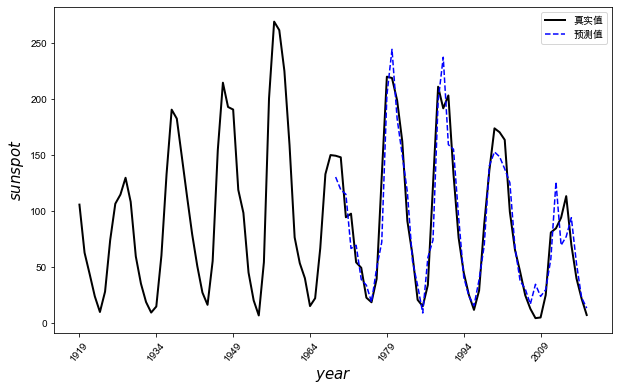

In [4]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial Unicode MS'
# 使用求出的参数，对后50年的数据逐年预测
predsData = []

for i in range(rows - 50,rows):
    t0 = ss_data.sunspot.values[i - a_d]
    if t0 <= a_tsv:
        predsData.append(np.sum(np.r_[1,ss_data.sunspot.values[(i-a_p1):i]]*coef1))
    else:
        predsData.append(np.sum(np.r_[1,ss_data.sunspot.values[(i-a_p2):i]]*coef2))


plt.figure(figsize=(10,6))
plt.plot(range(rows)[-100:rows],ss_data.sunspot[-100:rows],'-',c='black',linewidth=2,label="真实值")
plt.plot(range(rows)[-50:rows],predsData,'b--',label="预测值")
plt.xticks(range(rows)[-100:rows][::15],ss_data.year[-100:rows][::15],rotation=50)
plt.xlabel("$year$",fontsize=15)
plt.ylabel("$sunspot$",fontsize=15)
plt.legend()
plt.show()